In [14]:
import sys, os
import sqlite3
import pandas as pd
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from math import factorial as fact

## Exploration of the Jaccard Index

In this part of the EDA, we will explore the importance of the Jaccard index as an indicator of similarity among songs. 


Before doing so, we have to connect to the database we have already created.

In [15]:
# create a new database by connecting to it
conn = sqlite3.connect("spotifyDB.db")
cur = conn.cursor()

In [16]:
# read the table to ensure that everything is working
pd.read_sql_query("select * from tracks WHERE num_member > 10 LIMIT 5;", conn)

,track,track_name,album,album_name,artist,artist_name,duration_ms,playlist_member,num_member
0,4HPBYMNnpP9Yc8u51VUyaD,Mariconatico,5bZ7Jgk7YE35ULHWO3wgHP,Sincopa,07PdYoE4jVRF6Ut40GgVSP,Cartel De Santa,269333,"1065,9003,10561,15769,21028,138066,147268,1567...",11
1,3MCMHJ0p0tD0eRQC0Wg7Wu,Headshot!,3k4aYVzOplQp6MTye2KlQ0,Unbreakable,4Uc6biA3i00oRAWvIfjhlk,MyChildren MyBride,210813,"3647,14323,35549,71836,74701,98691,113560,1189...",13
2,2F950w5JasEsPPHfspO5yn,Know Your Onion - Spotify Sessions Curated by ...,5aeSTpjqwuarRBM1zPCbOY,Spotify Sessions,4LG4Bs1Gadht7TCrMytQUO,The Shins,152653,"2136,5176,27542,55583,77394,85407,118872,18360...",11
3,5GAU7SP15OkPwj2tjXlUJn,Goodfriend,2kyzu2gZ1SlkrzW6l4b7dD,Feathers & Fishhooks,251UrhgNbMr15NLzQ2KyKq,Rayland Baxter,266746,"3626,8788,17107,49060,52900,53173,64212,66550,...",15
4,7bTNGfXSJthLunBJzgOyBw,Harder,5nL2ZC8NBSjMZfgpOp9P0w,FLYTRAP,41yEdWozNYEzA2RfgYQHgr,CJ Fly,177842,"17432,30221,51929,53295,74242,86976,109832,139...",11


In [40]:
# read the table
pd.read_sql_query("select * from playlists LIMIT 5;", conn)

,track,track_name,album,album_name,artist,artist_name,duration_ms,playlist_member,num_member
0,1Pm3fq1SC6lUlNVBGZi3Em,Concerning Hobbits (The Lord of the Rings),3q8vR3PFV8kG1m1Iv8DpKq,Versus Hollywood,7zdmbPudNX4SQJXnYIuCTC,Daniel Tidwell,108532,2,1
1,6BAwTzs5CWWuaaOpp6mTeL,End It Now!,4SKnp9LlgXiEeVVud74fTS,Arrows,4Xo1N4V7w6qX23OHAPcLCe,The Lonely Forest,261146,4,1
2,3Ex4oMC0UeAQNAG78AuVfi,Pink City,4ukM0IdJpt2NL8F8kDebS7,A Promise,5JLqvjW3Nyom2OsRUyFsS9,Xiu Xiu,133373,4,1
3,17q3q8wMWgYB8HoqZNNMRT,So Much Love So Little Time,3jlchQb5BMfS7Cug5iceJn,Live A Little Love A Lot,5juac7bFYyLKmV0VGSyaKM,Moose,202533,4,1
4,6AAWJJ0zamfEVReLLDj4BC,Screaming,5xxnHsOdealeAwAjfJfWH6,. . . XYZ,5juac7bFYyLKmV0VGSyaKM,Moose,233733,4,1
5,1KVU56xCG8SqaXRjf9n4Da,Crush The Camera,0ZvFi6ooJJOuMuMWfHAstk,10:1,2JSc53B5cQ31m0xTB7JFpG,Rogue Wave,180666,4,1
6,7331X4zR3C2eaLh5iHN98k,Interference,5mmZbh9XqQaR0AEeevo5TS,Interference / Smile & Gesture,3X03NfrYVLMXS2kz13t5WU,Lets Kill Janice,212661,4,1
7,3O7HL3mzobCIxzErIMijxJ,Spread A Little Sunshine,3Ll91eivgGYSJUVnL1WV4h,Playground,3K6DKtqcjx8Vs5XEaTgZv7,The Truth,213466,4,1
8,5La66MFvn7AX8ZjXu2s8l8,Kalte Wut / Wenn Ich Einmal Reich Bin,6u6ISXvYPQkgzAQ170HUO0,Lucky Streik,04QGT0sr98LHIUjqPJ4RG4,Floh de Cologne,313066,4,1
9,3vUTaQZGXUTqgYWNUZiNW8,Love's Been Good To Me,27MGNEcpVfyejgypNIkogw,One by One,62JorFOkIjXHHU7GMT9r77,Rod McKuen,183493,4,1


First of all, here we define functions that we will later use. 

In [7]:
# this function creates all the unique pairwise combination of tracks within a playlist
def create_pair_from_playlist(playlist_id):
    query = 'SELECT tracks FROM playlists WHERE playlist_id = {};'.format(playlist_id)
    all_tracks = pd.read_sql_query(query, conn)
    ids = all_tracks['tracks'].values[0].split(',')
    track_pairs = [(track1, track2) for i, track1 in enumerate(ids) 
               for j, track2 in enumerate(ids) if i<j]
    return track_pairs

In [8]:
# this function returns jaccard index between a pair of tracks (in tuple)
def similarity_btw_pair(pair_tuple):
    track_id1 = pair_tuple[0]
    track_id2 = pair_tuple[1]
    query = 'SELECT playlist_member, num_member FROM tracks WHERE track IN ("{}","{}");'.format(track_id1, track_id2)
    track_data = pd.read_sql_query(query, conn)
    
    mem1 = track_data['playlist_member'].values[0].split(',')
    mem2 = track_data['playlist_member'].values[1].split(',')
    num1 = track_data['num_member'].values[0]
    num2 = track_data['num_member'].values[1]
    # take intersect and union
    intersect = len(set(mem1).intersection(mem2))
    union = len(list(set(mem1) | set(mem1)))
    
    jaccard = intersect/union
    
    por1 = intersect/num1
    por2 = intersect/num2
    
    return jaccard, intersect, union, por1, por2

## Jaccard index mean

We will pick 1000 different playlists, and then compute the mean Jaccard index from all the possible song combinations within each playlist. 

Then, we will use the average number of songs within a playlist to pick random songs from the database, and thus find the mean Jaccard index for 1000 sets of random songs (not bootstrapped).

Here, we take 1000 random playlists:

In [54]:
# Pick 1000 random playlists
N = 1000

playlists = pd.read_sql_query('SELECT * FROM playlists ORDER BY RANDOM() LIMIT {};'.format(N), conn)

In [70]:
# How many songs per playlist?

mean_tracks = playlists[['num_tracks']].mean()

In [56]:
# Saving the jaccard means

# ATTENTION-- this cell takes hours to run.

jaccard_means = []

for i, playlist in playlists.iterrows():
    playlist_id = playlist.playlist_id
    track_pairs = create_pair_from_playlist(playlist_id)
    jaccard = []

    for pair_tuple in track_pairs:
        j,_,_,_,_ = similarity_btw_pair(pair_tuple)
        jaccard.append(j)
        
    jaccard = np.array(jaccard)
    jaccard_mean = np.mean(jaccard)
    
    jaccard_means.append(jaccard_mean)
    

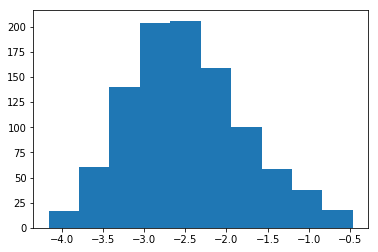

In [66]:
# Distribution of the LOG of the jaccard index means

plt.hist(np.log(jaccard_means));
plt.title('Jaccard Index- means for indices within playlists')

## For the random playlists:

To find out how many random tracks we need to pick in order to explore the indices between random songs (instead of songs that exists in the same playlist), we need to compute the possible combinations of track from a 67 track playlist (67 an example mean size of a playlist), given by:
$$ \frac{n!}{(n-k)! k!}$$
where n = 67 and k =2.

In order to create the random pairs from which the Jaccard indices will be calculated, we will pick twice that number of tracks, split the list of them into two, and then pair the two resulting lists up.

In [115]:
#For the number of random tracks:

mean_tracks_int = int(mean_tracks)

# Multiply by 2 because we intend to split the list
n_rand_tracks = int(2 *fact(mean_tracks_int)/(fact(mean_tracks_int-2)*fact(2)))

In [ ]:
# Function that splits a list into two

def split_list(A):
    half = len(A)//2
    B = A[:half]
    C = A[half:]
    
    return B, C

In [ ]:
# Find random tracks, make sure there's no duplicates, split list and join as tuples (ONLY ONE)

rand_tracks = pd.read_sql_query('SELECT track FROM tracks ORDER BY RANDOM() LIMIT {};'.format(n_rand_tracks), conn)
rand_tracks = list(set(rand_tracks[['track']].values[:,0]))

rand_list_a, rand_list_b = split_list(rand_tracks)
rand_tracks_paired = list(zip(rand_list_a, rand_list_b))


In [ ]:
# Compute jaccard for one

jaccard_temp=[]
for pair in rand_tracks_paired:
    j_rand,_,_,_,_ = similarity_btw_pair(pair)
    jaccard_temp.append(j_rand)
    
jaccard_temp = np.array(jaccard_temp)
mean_pls = np.mean(jaccard_temp)

In [116]:
# Random tracks jaccard means

jaccard_rand_means = []
for i in range(N):
    rand_tracks = pd.read_sql_query('SELECT track FROM tracks ORDER BY RANDOM() LIMIT {};'.format(n_rand_tracks), conn)
    rand_tracks = list(set(rand_tracks[['track']].values[:,0]))

    rand_list_a, rand_list_b = split_list(rand_tracks)
    rand_tracks_paired = list(zip(rand_list_a, rand_list_b))
    
    jaccard_temp=[]
    for pair in rand_tracks_paired:
        j_rand,_,_,_,_ = similarity_btw_pair(pair)
        jaccard_temp.append(j_rand)

    jaccard_temp = np.array(jaccard_temp)
    mean_rand_jaccard = np.mean(jaccard_temp)
    
    jaccard_rand_means.append(mean_rand_jaccard)
    i += 1
    

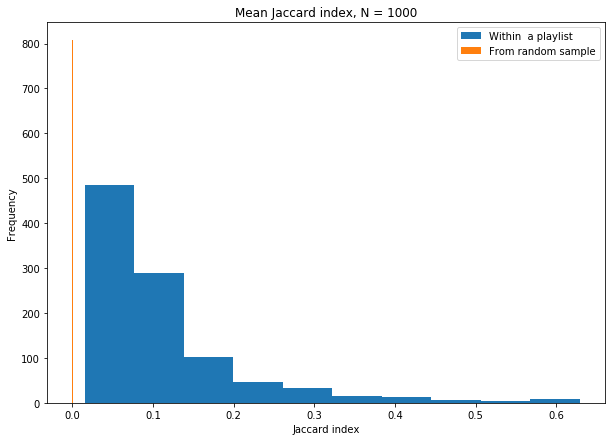

In [124]:
# Plot

plt.figure(figsize = (10,7))
plt.title('Mean Jaccard index, N = {}'.format(N))
plt.hist(jaccard_means, label='Within  a playlist')
plt.hist(jaccard_rand_means, label='From random sample')
plt.xlabel('Jaccard index')
plt.ylabel('Frequency')
plt.legend()

From this histogram, we see that there's clearly two separate populations-- the Jaccard index is much larger for songs that are 'related' (they're together in playlists).

---------

## Content analysis: Can we predict a Jaccard index from audio features?

First of all, we can pick a random song, and explore what playlists it is in. Instead of just looking at the Jaccard index between it and a single playlist it is in, it would be more interesting to explore songs from ALL the playlists it is in, and then compare it to random songs.

Essentially, we will try to see if there's a linear connection between the audio features of a song, and the Jaccard index between it and a random other song.

We are picking an equal distribution of random songs, and songs that populate the same playlists as the reference song, in order to ensure that there's a distribution of Jaccard indices (given that most will hae an index of zero).


In [247]:
# First, pick a random track

track_EDA = pd.read_sql_query("SELECT * from tracks WHERE num_member > 3 ORDER BY RANDOM() LIMIT 1;", conn)

In [265]:
# Parse all the playlists for a single track:

track_EDA_playlists = track_EDA[['playlist_member']].values[0]
track_EDA_playlists = [x.strip() for x in track_EDA_playlists[0].split(',')]
track_EDA_playlists = [int(x) for x in track_EDA_playlists]


In [290]:
# Find all tracks that should have a higher Jaccard index from the playlists
EDA_ids = []
for playlist_id in track_EDA_playlists:
    query = 'SELECT tracks FROM playlists WHERE playlist_id = {};'.format(playlist_id)
    all_tracks = pd.read_sql_query(query, conn)
    ids = all_tracks['tracks'].values[0].split(',')
    EDA_ids.append(ids)

# Flatten the list
EDA_ids = [item for sublist in EDA_ids for item in sublist]

# Make unique and drop track
EDA_ids = list(set(EDA_ids))

track1 = track_EDA[['track']].values[0][0]

# Ensure that the tracks do NOT contain the track itself
EDA_ids.remove(track1)


# Make tuples

track_pairs_EDA = [(track1, track2) for track2 in EDA_ids]


In [291]:
# Between this song and random songs:

len_EDA = len(EDA_ids)

# Then pick the same number of songs

tracks_rand_EDA = pd.read_sql_query("SELECT * from tracks ORDER BY RANDOM() LIMIT {};".format(len_EDA), conn)


In [292]:
# Place the IDs of the random song into a list, and ensure only unique values

EDA_rand_ids = tracks_rand_EDA['track'].values.tolist()
EDA_rand_ids = list(set(EDA_rand_ids))

# Make sure the reference song itself is not in the playlist
try:
    EDA_rand_ids.remove(track1)
except:
    pass

# Concatenate lists
EDA_ids = EDA_ids+EDA_rand_ids

# Create tuples
track_pairs_EDA = [(track1, track2) for track2 in EDA_ids]

In [293]:
# Jaccard
jaccard_EDA = []

for pair_tuple in track_pairs_EDA:
    j_EDA,_,_,_,_ = similarity_btw_pair(pair_tuple)
    jaccard_EDA.append(j_EDA)
    

In [294]:
# Collect audio features:
import spotipy as sp
import spotipy.oauth2 as oauth2
import sqlite3
import pandas as pd

# set up authorization token
credentials = oauth2.SpotifyClientCredentials(
        client_id='153369a05314402294db1a574caaff2a',
        client_secret='c6fff0923a0c44c5851fc4415038e8fa')

token = credentials.get_access_token()
spotify = sp.Spotify(auth=token)

In [295]:
# All audio features -- for regression purposes

danceability = []
energy = []
key = []
loudness = []
mode = []
speechiness = []
acousticness = []
instrumentalness = []
liveness = []
valence = []
tempo = []
duration_ms = []
time_signature = []

# Collect into lists:

for track_id in EDA_ids:
    results = spotify.audio_features(tracks=track_id)
    
    # Add into lists
    danceability.append(results[0]['danceability'])
    energy.append(results[0]['energy'])
    key.append(results[0]['key'])
    loudness.append(results[0]['loudness'])
    mode.append(results[0]['mode'])
    speechiness.append(results[0]['speechiness'])
    acousticness.append(results[0]['acousticness'])
    instrumentalness.append(results[0]['instrumentalness'])
    liveness.append(results[0]['liveness'])
    valence.append(results[0]['valence'])
    tempo.append(results[0]['tempo'])
    duration_ms.append(results[0]['duration_ms'])
    time_signature.append(results[0]['time_signature'])
    
    

retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs


In [296]:
# Create a dict, in order to make a pandas DataFrame
EDA_data = {}

EDA_data['ids']= EDA_ids
EDA_data['jaccard_EDA'] = jaccard_EDA

# Audio features
EDA_data['danceability']= danceability
EDA_data['energy']= energy
EDA_data['key']= key
EDA_data['loudness']= loudness
EDA_data['mode']= mode
EDA_data['speechiness']= speechiness
EDA_data['acousticness']= acousticness
EDA_data['instrumentalness']= instrumentalness
EDA_data['liveness']= liveness
EDA_data['valence']= valence
EDA_data['tempo']= tempo
EDA_data['duration_ms']= duration_ms
EDA_data['time_signature']= time_signature

EDA_results = pd.DataFrame.from_dict(EDA_data)

In [384]:
# Resulting pd:
EDA_results.head()

,ids,jaccard_EDA,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,6pK6XXI3JHudVtl77QAfhh,0.024390,0.547,0.395,0,-9.654,0,0.0396,0.7850,0.000016,0.1240,0.697,140.992,197293,4
1,5BsOb3PMGwsMKTRpkabonh,0.073171,0.655,0.692,6,-11.728,1,0.0303,0.1640,0.000000,0.8210,0.668,111.253,183827,4
2,1dFITmhIit06htQ6dBRQOS,0.500000,0.830,0.649,8,-6.789,0,0.1510,0.0829,0.000220,0.0792,0.456,123.979,367960,4
3,7Lg5osturAd2VUP1rf0tEU,0.024390,0.369,0.477,7,-8.836,1,0.0354,0.7180,0.000037,0.1040,0.524,94.904,189213,4
4,27wLc0cxnw9IbhRMyMeBmR,0.333333,0.775,0.553,1,-10.512,1,0.0308,0.4850,0.842000,0.0453,0.820,120.005,286093,4


In [314]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

# Response and independent variables:
X_vars = EDA_results[['danceability', 'energy', 'key', 'loudness', 'mode','speechiness', \
                      'acousticness','instrumentalness','liveness', 'valence', 'tempo', \
                      'duration_ms', 'time_signature']]

response = EDA_results[['jaccard_EDA']]

# Split:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_vars,response,test_size=0.2)


# Random Forest Regression using OOB (lab 9)

In order to do the regression, we can start with a random forest.

In [331]:
from sklearn.ensemble import RandomForestRegressor

# Code from lab 9, and:
# Adventures in scikit-learn's Random Forest by Gregory Saunders
from itertools import product
from collections import OrderedDict

param_dict = OrderedDict(
    n_estimators = [200, 400, 600, 800],
    max_features = [0.2, 0.4, 0.6, 0.8]
)

param_dict.values()

odict_values([[200, 400, 600, 800], [0.2, 0.4, 0.6, 0.8]])

In [332]:
from itertools import product

In [333]:
# Use Random Forest, and pick the best combination:
ytrain = np.ravel(ytrain)
RF_results = {}
RF_estimators = {}
for Ntrees, maxfeat in product(*param_dict.values()):
    params = (Ntrees, maxfeat)
    RF = RandomForestRegressor(oob_score=True, 
                                n_estimators=Ntrees, max_features=maxfeat, max_depth=50)
    RF.fit(Xtrain, ytrain)
    RF_results[params] = RF.oob_score_
    RF_estimators[params] = RF
best_params = max(RF_results, key = RF_results.get)
best_params

(600, 0.2)

In [344]:
# Check accuracy
RF_final = RF_estimators[best_params]
print('The resulting accuracy from the RF is', RF_final.score(Xtest, ytest)*100, '%')

The resulting accuracy from the RF is 7.116939558688562 %


In [2]:
# Plot based on significance
pd.Series(RF_final.feature_importances_,index=list(Xtrain)).sort_values().plot(kind="barh")

NameError: name 'pd' is not defined

This is very low accuracy, so regression does not seem too appealing. In any case, we can try a different method before rejecting the regression based on linearity.


## Boosting

Last effort before rejecting this method will be boosting, using the "best predictors" from the previous analysis.

In [359]:
# Drop the worst predictors
ind_todrop = [index for index, value in enumerate(RF_final.feature_importances_) \
              if value < RF_final.score(Xtest, ytest)*0.5]

Xtrain_new = Xtrain.copy()

for ind in ind_todrop:
    col_todrop = Xtrain.columns[ind]
    Xtrain_new.drop(col_todrop, axis = 1)
    

We're going to use the best parameters from the random forest eda

In [372]:
#Fit an Adaboost Model

from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

boosts = {}
boost_results = {}

for n in range(2,20):
    boost_model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=n),\
                                    n_estimators=best_params[0],\
                                    learning_rate=0.05)
    boost_model.fit(Xtrain_new, ytrain)
    boosts[str(n)] = boost_model
    
    boost_results[str(n)] = boost_model.score(Xtest, ytest)
    

In [381]:
#Best depth accuracy

best_depth = max(boost_results, key = boost_results.get)
boost_final_score = boost_results[best_depth]

print('The best boosting model has a max_depth of {0} with a score of {1}%'.format(best_depth,100*boost_final_score))


The best boosting model has a max_depth of 11 with a score of 8.28111106007271%


This is stillnot a satisfactory accuracy score, which shows the need for both a different content-based analysis, and a collaborative filtering approach.

In [382]:
# note! always close the connection at the end
cur.close()
conn.close()